In [1]:
import pickle
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pickle
import torch
from torch.nn.functional import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
model_id = 5
embeddings_path = f"{DATA_PATH}/Models/disentangled_representations/inference/{model_id}/{model_id}.pkl"

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)
# Remove #.jpg from all filenames
embeddings['filenames'] = [f.split('.')[0] for f in embeddings['filenames']]

embeddings.keys()

dict_keys(['filenames', 'dinov2_vitb14', 'disentangled_embeddings', 'predicted_labels'])

In [4]:
# Concatenate all subspaces as the final embedding
embeddings['disentangled_embeddings_concat'] = torch.cat([embeddings['disentangled_embeddings'][key] for key in embeddings['disentangled_embeddings'].keys()], dim = 1)

In [5]:
def calculate_typicality_scores(embedding_type):
    # Calculate morph
    if embedding_type in embeddings['disentangled_embeddings'].keys():
        morph = embeddings['disentangled_embeddings'][embedding_type].mean(dim = 0)
        sims = [cosine_similarity(morph, embeddings['disentangled_embeddings'][embedding_type][i], dim = 0).item() for i in range(embeddings['disentangled_embeddings'][embedding_type].shape[0])]
    else: 
        morph = embeddings[embedding_type].mean(dim = 0)
        sims = [cosine_similarity(morph, embeddings[embedding_type][i], dim = 0).item() for i in range(embeddings[embedding_type].shape[0])]
    typicality_scores = dict(zip(embeddings['filenames'], sims))    
    return typicality_scores

In [6]:
typicality_scores = {embeddings_type:calculate_typicality_scores(embeddings_type) for embeddings_type in ['dinov2_vitb14', 'disentangled_embeddings_concat'] + list(embeddings['disentangled_embeddings'].keys())}
typicality_scores.keys()

dict_keys(['dinov2_vitb14', 'disentangled_embeddings_concat', 'Color', 'Fabric', 'Fit', 'Neckline', 'Pattern', 'Collar', 'Length', 'Shape', 'Sleeve_Length'])

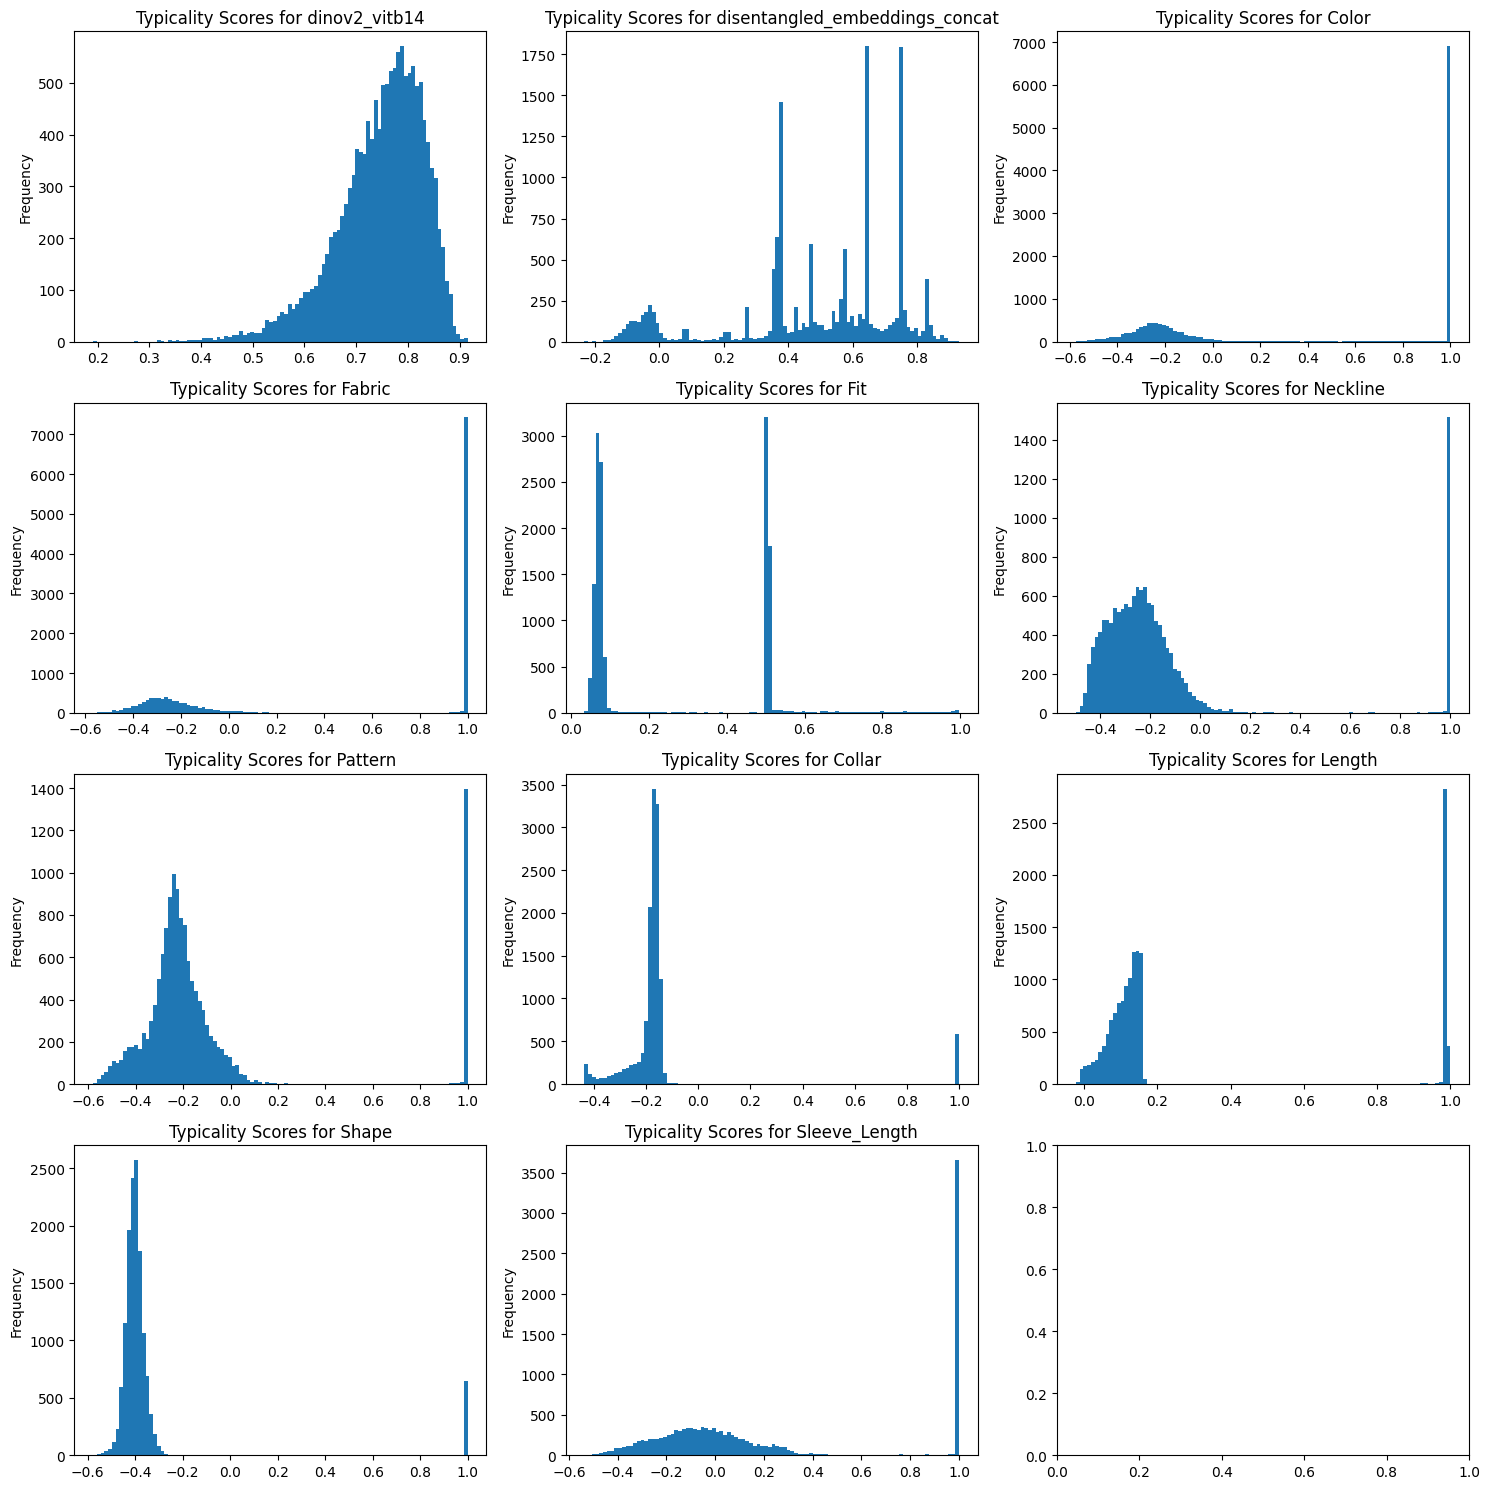

In [7]:
fig, ax = plt.subplots(4,3, figsize = (15,15))
axs = ax.flatten()
for i, embedding_type in enumerate(typicality_scores.keys()):
    d = pd.Series(typicality_scores[embedding_type])
    d.plot(kind = 'hist', bins =100, ax = axs[i])
    axs[i].set_title(f"Typicality Scores for {embedding_type}")
fig.tight_layout()
plt.show()

### Merge with Metadata of Products

In [13]:
# Import metadata
meta = pd.read_json(f'{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json').T.reset_index().rename(columns={'index':'sku'})
for embedding_type in typicality_scores.keys():
    meta[f"{embedding_type}_typicality"] = meta['sku'].map(typicality_scores[embedding_type])
meta.to_csv('disentangled_typicality_scores.csv', index = False)

### Plot some examples

In [9]:
# Load in e4e latents
e4e_latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

In [10]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [11]:
def plot_highest_lowest_typicality(embedding_type, n):
    global highest_typicality, lowest_typicality
    highest_typicality = meta.sort_values(by = f"{embedding_type}_typicality", ascending = False).head(n).reset_index()
    lowest_typicality = meta.sort_values(by = f"{embedding_type}_typicality", ascending = True).head(n).reset_index()

    fig, ax = plt.subplots(2,n, figsize = (20,7))
    axs = ax.flatten()
    for i, row in highest_typicality.iterrows():
        latent = e4e_latents[row['sku']]
        img = generate_from_latent(latent)
        axs[i].imshow(img)
        axs[i].axis('off')
        try: 
            axs[i].set_title(f"{row['sku']}\n{row[f'{embedding_type}_typicality']:.2f}\nLabel: {row[embedding_type.lower()]}")
        except:
            axs[i].set_title(f"{row['sku']}\n{row[f'{embedding_type}_typicality']:.2f}")

    for i, row in lowest_typicality.iterrows():
        latent = e4e_latents[row['sku']]
        img = generate_from_latent(latent)
        axs[i+n].imshow(img)
        axs[i+n].axis('off')
        try:
            axs[i+n].set_title(f"{row['sku']}\n{row[f'{embedding_type}_typicality']:.2f}\nLabel: {row[embedding_type.lower()]}")
        except:
            axs[i+n].set_title(f"{row['sku']}\n{row[f'{embedding_type}_typicality']:.2f}")

    fig.suptitle(f"Most/Least typical images according to {embedding_type}")
    fig.tight_layout()
    plt.show()


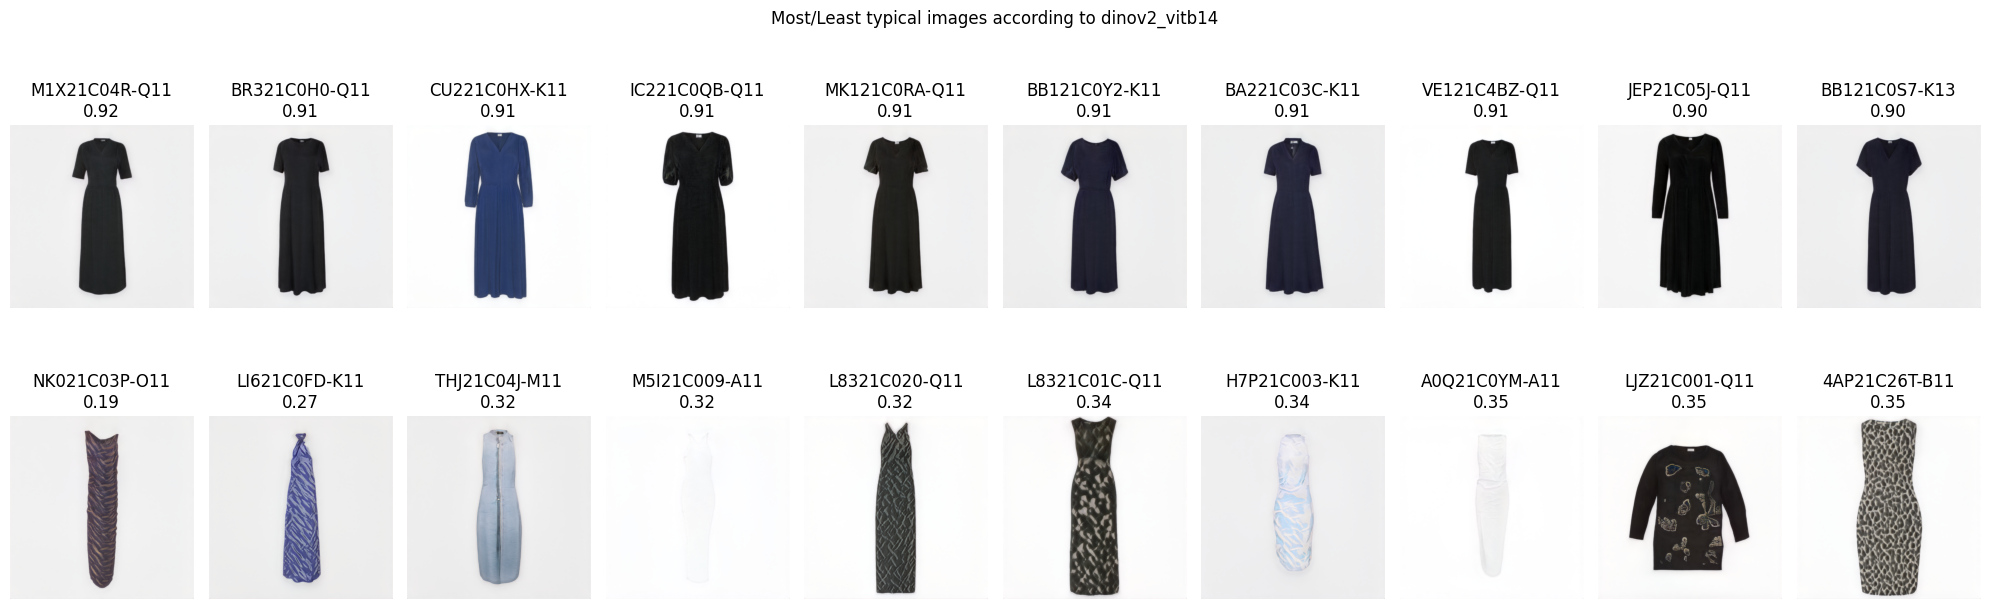

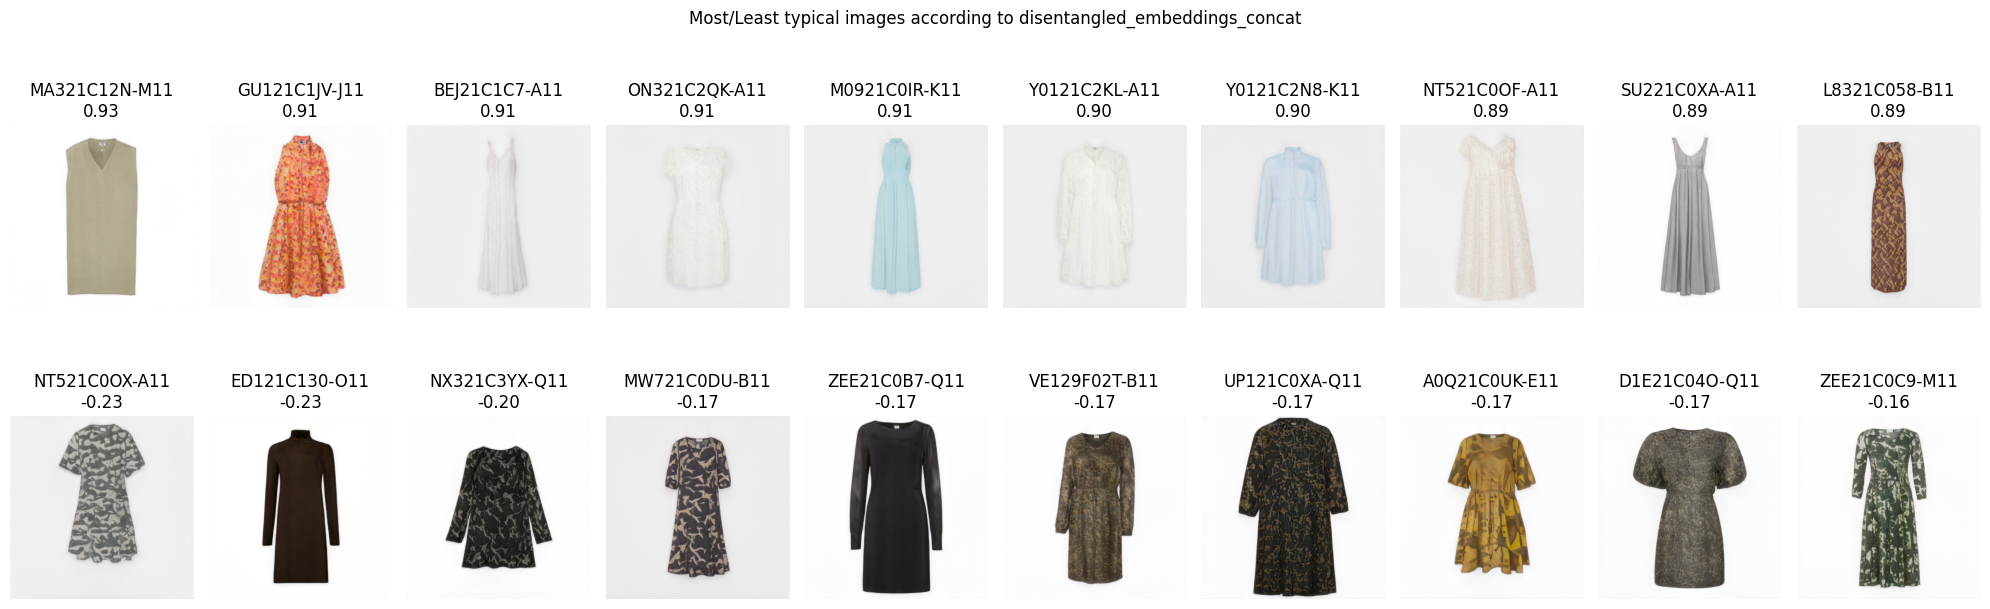

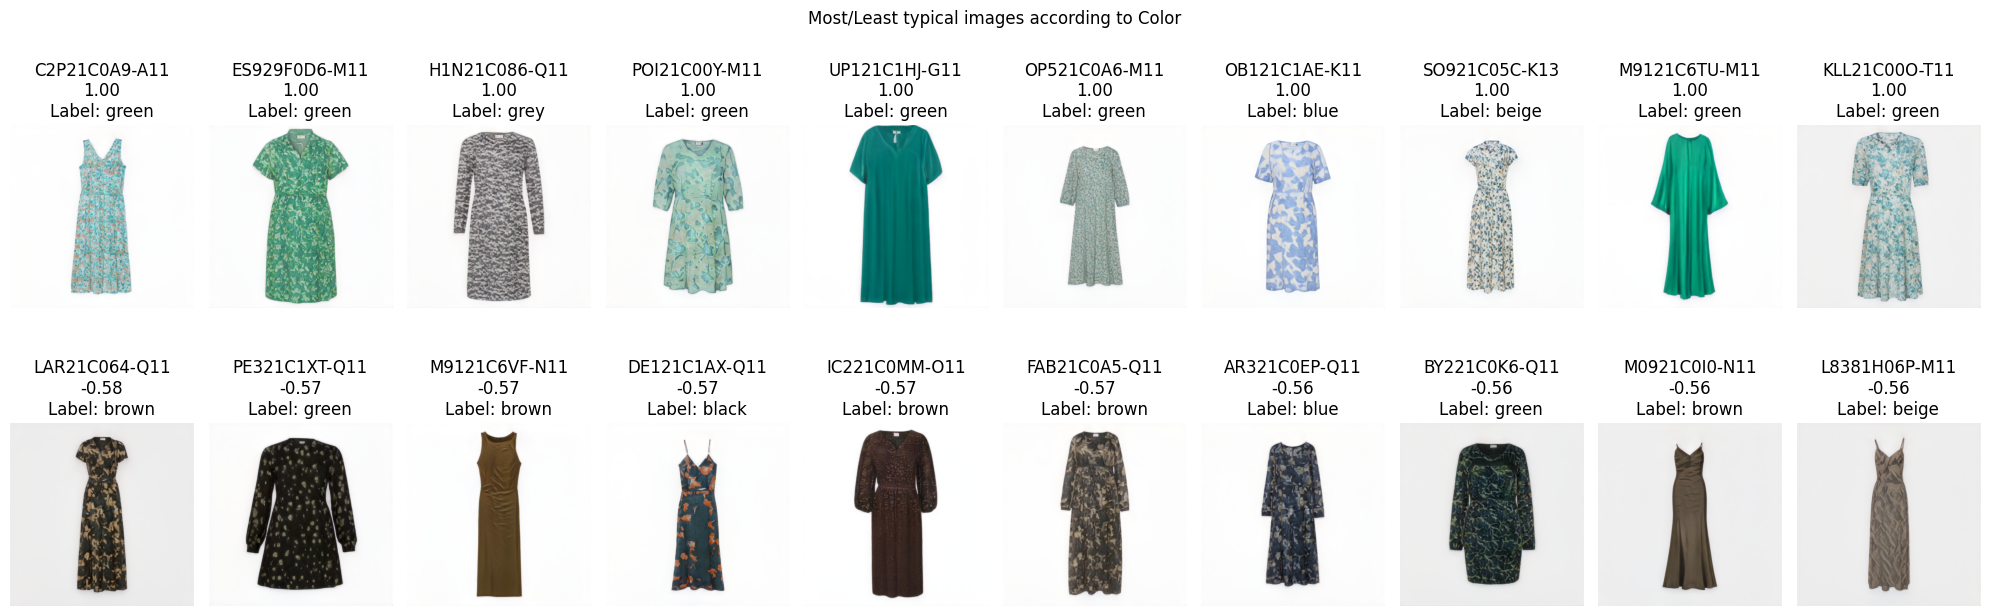

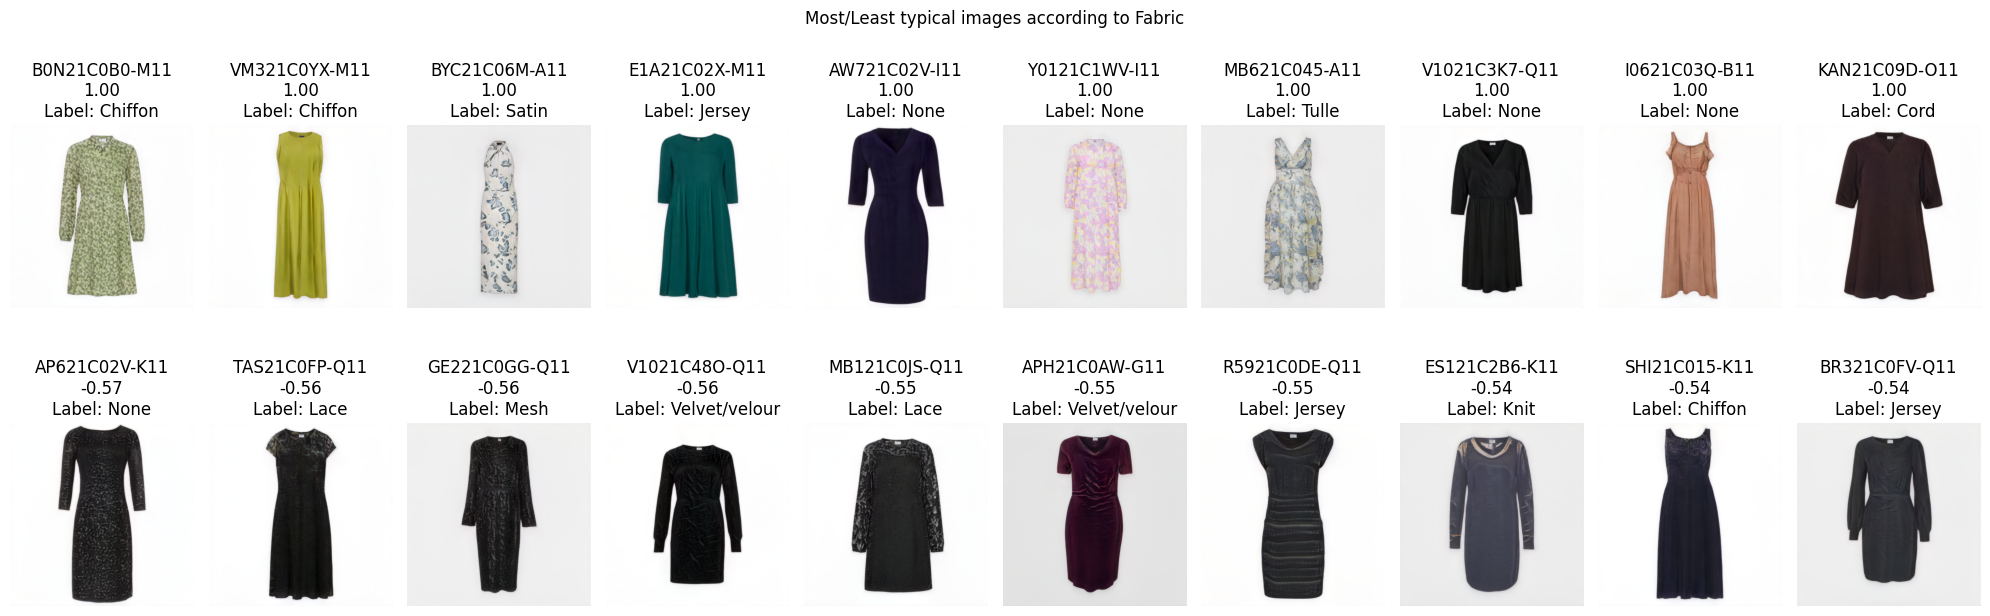

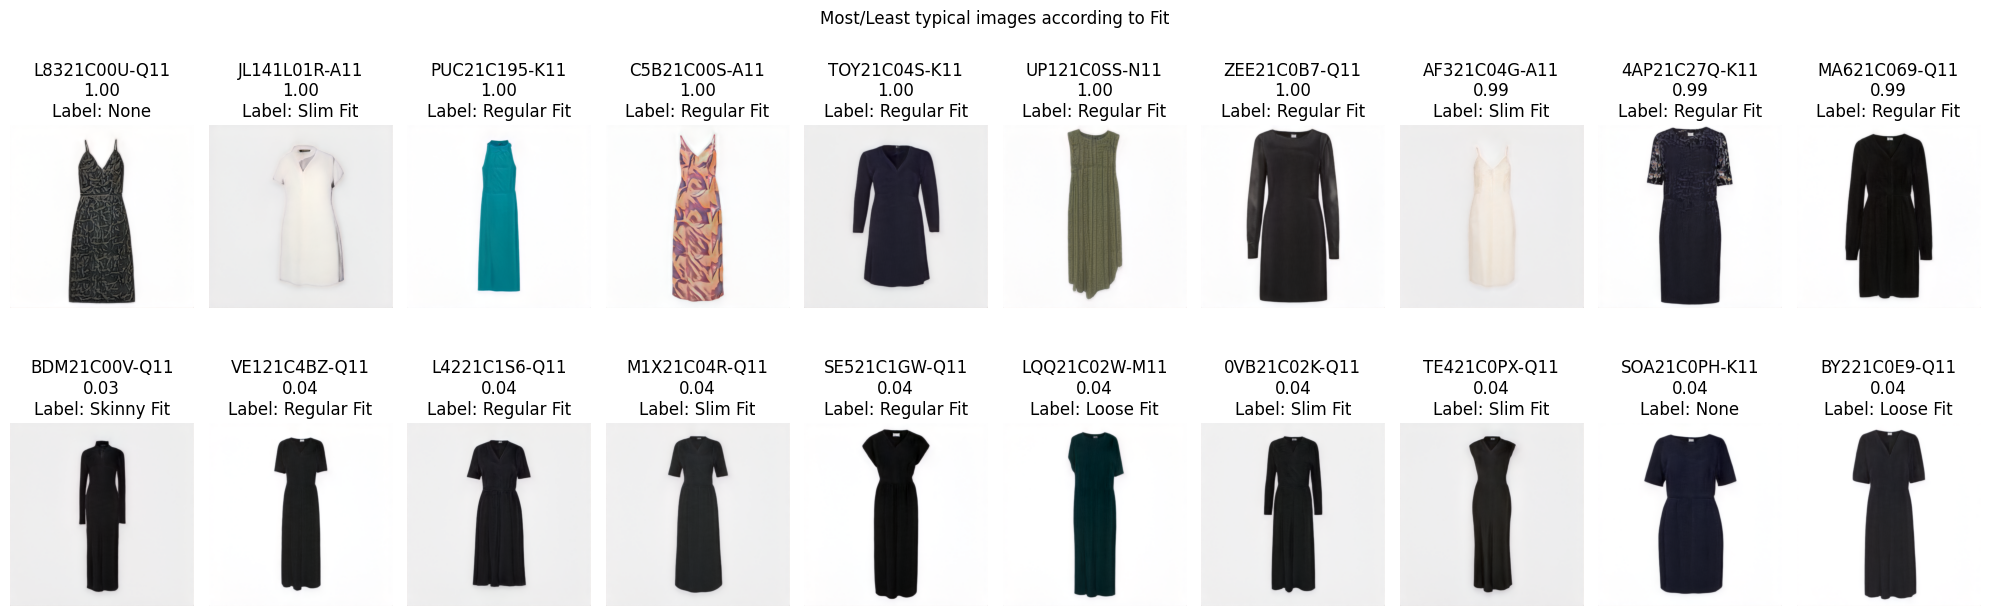

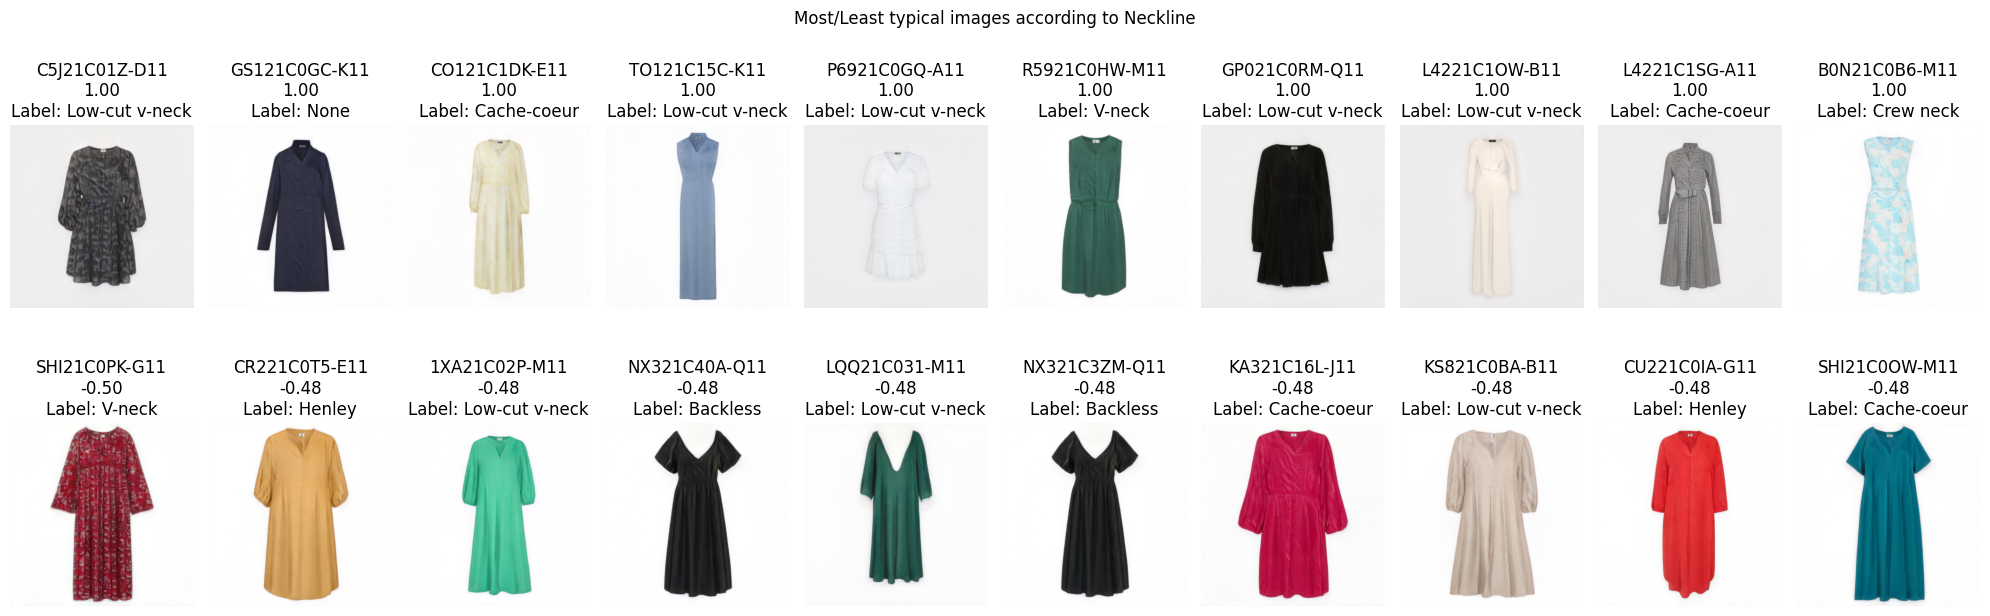

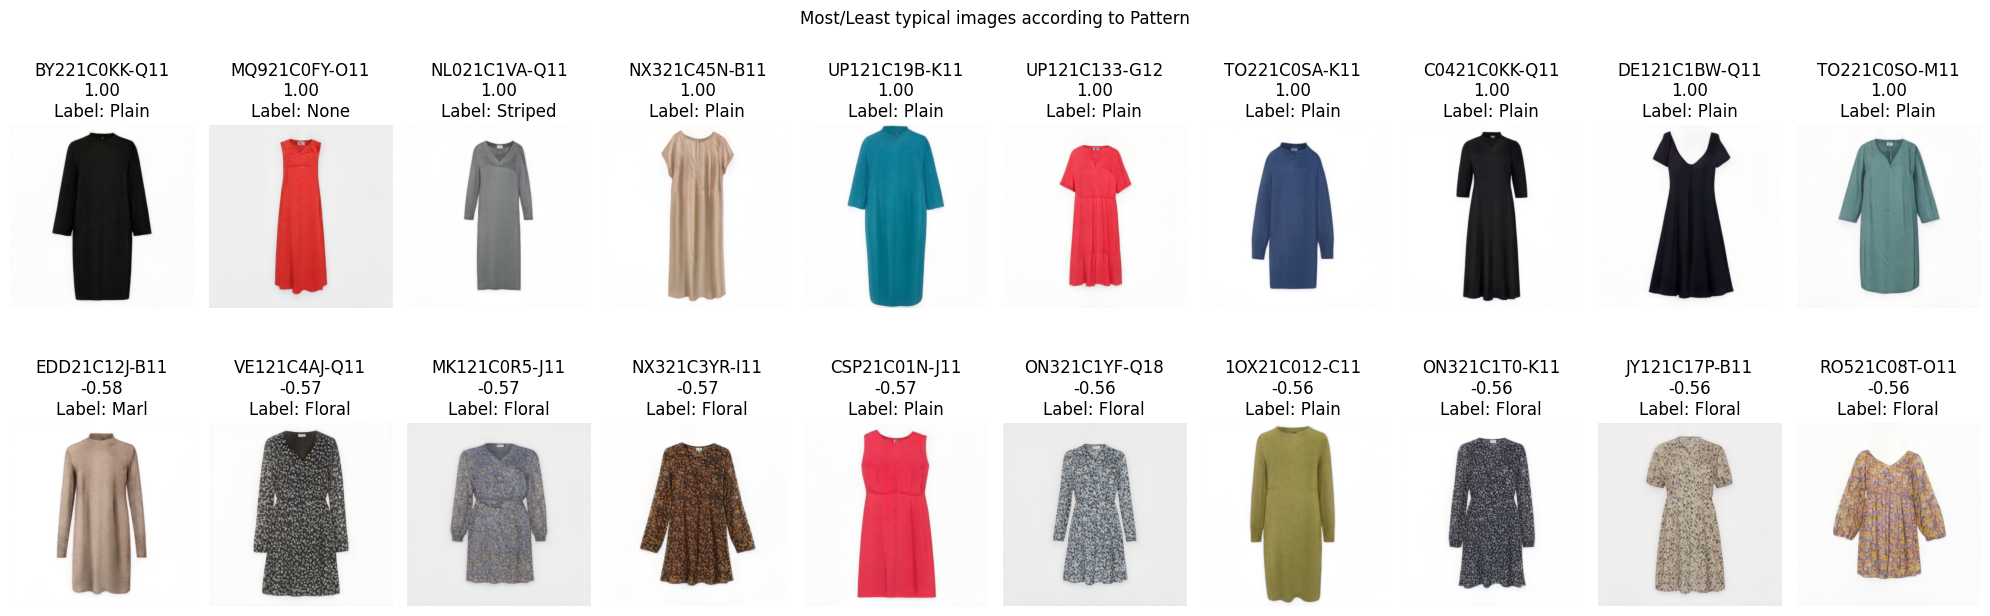

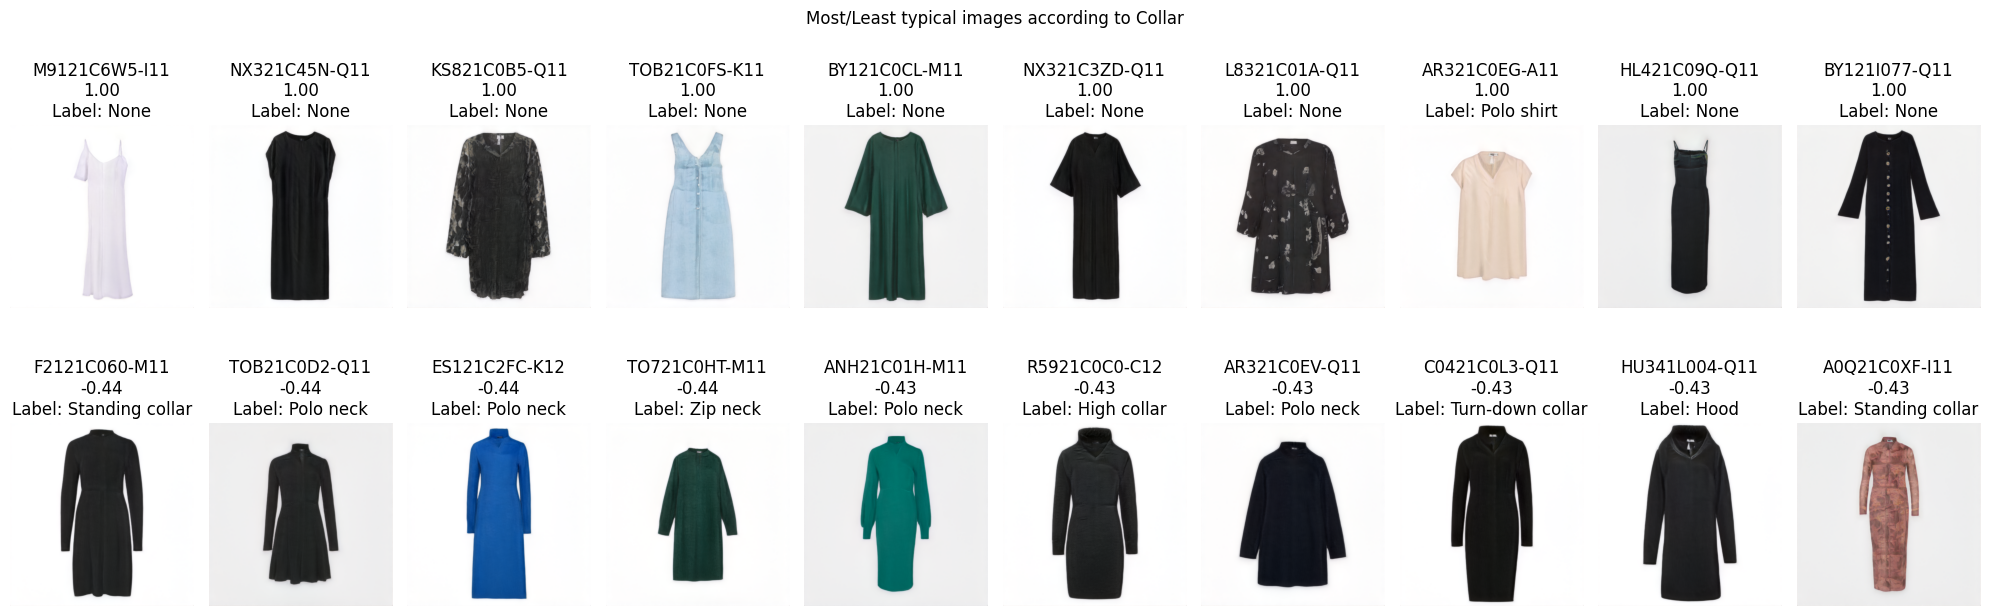

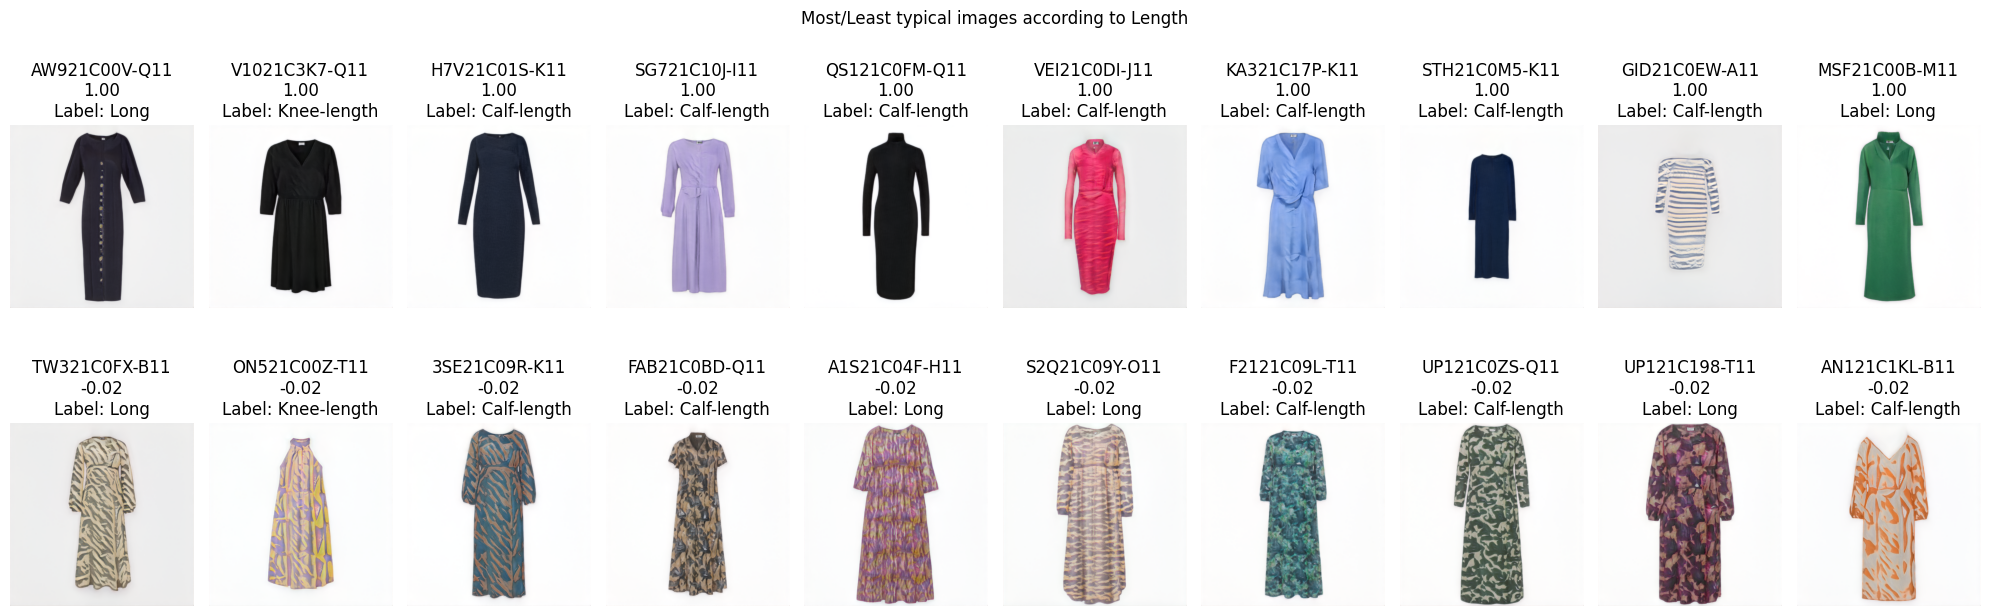

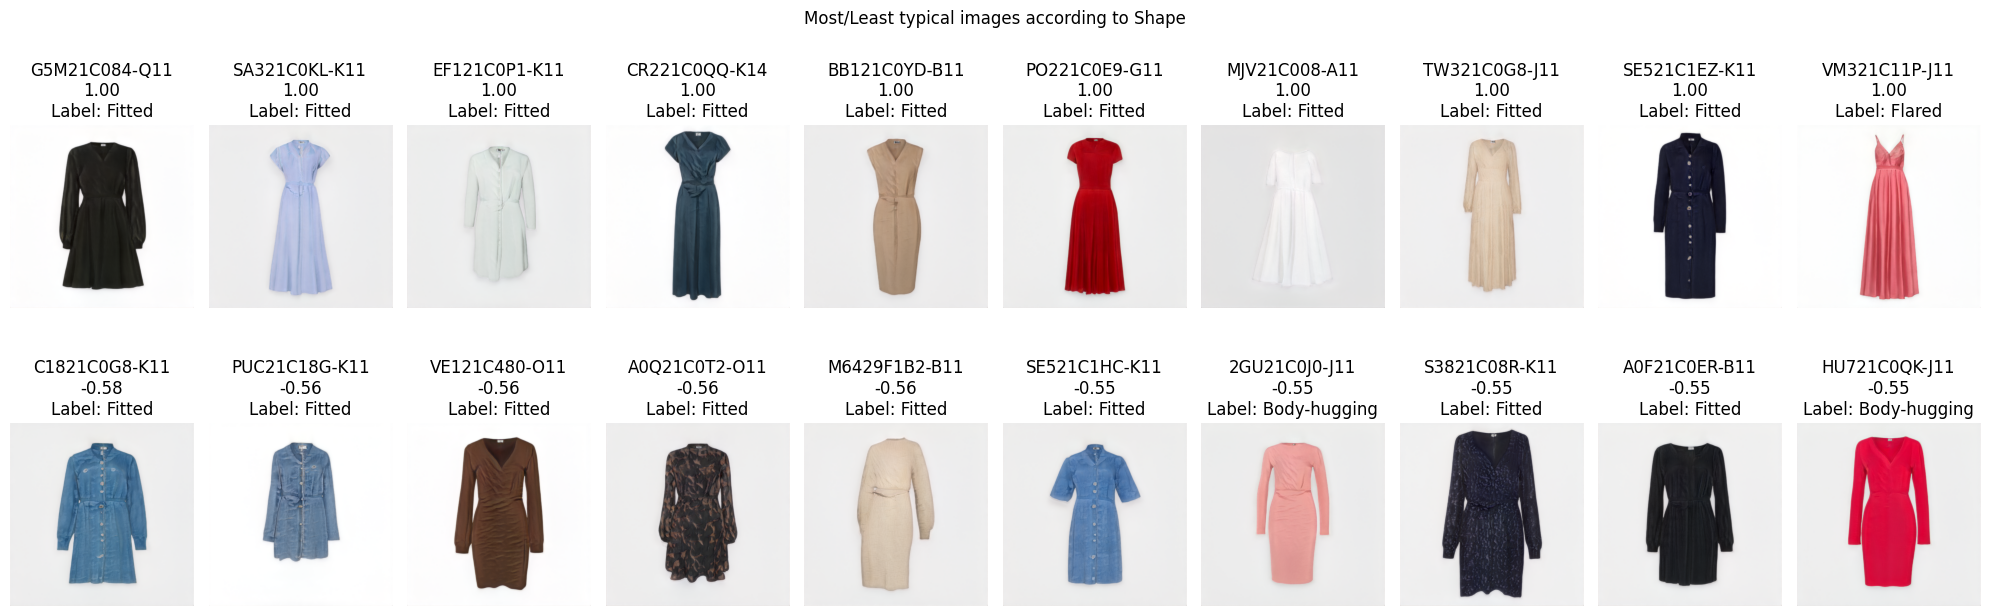

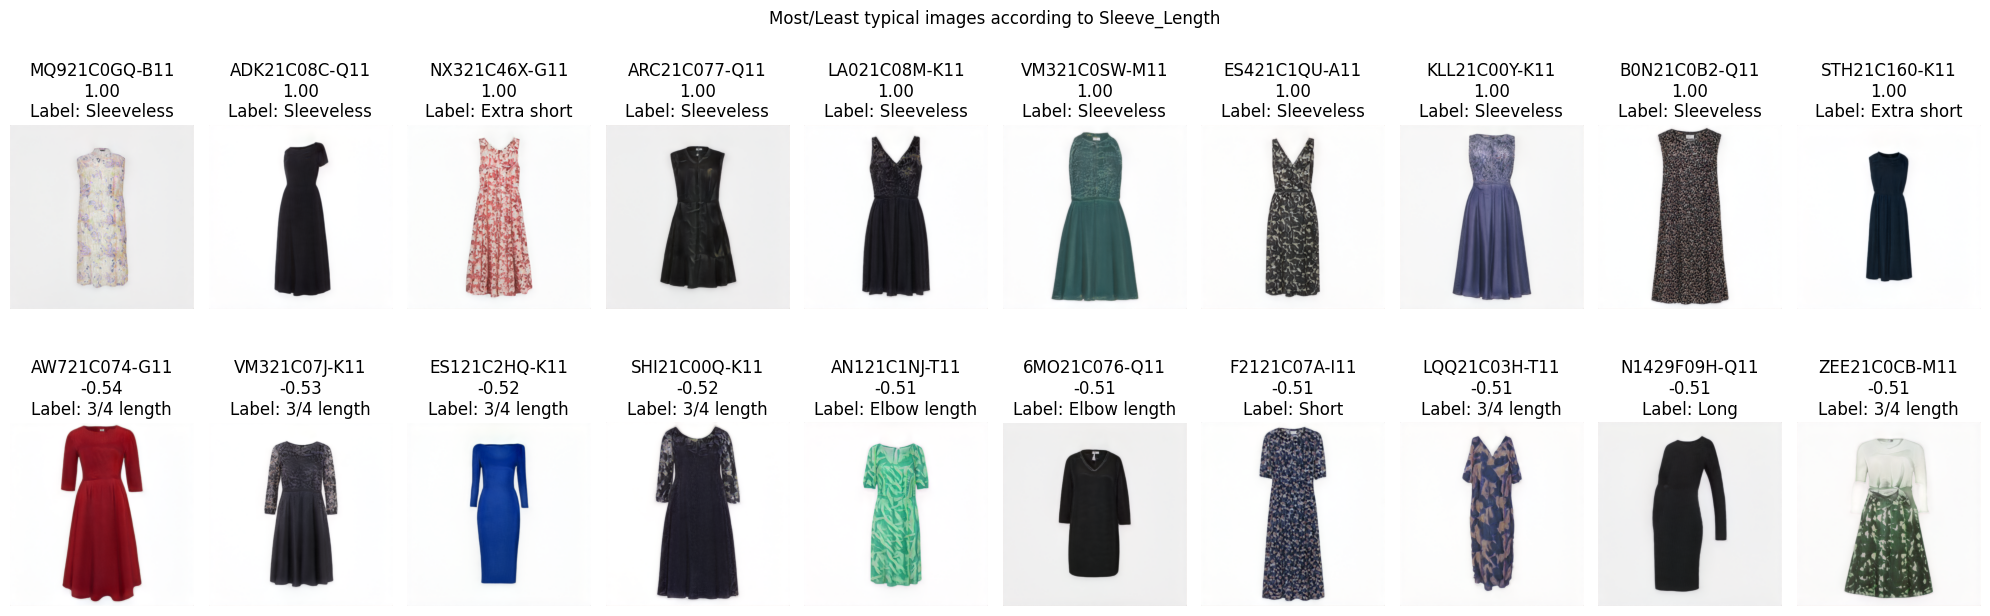

In [12]:
# Plot n highest and lowest typicality scores
for embedding_type in typicality_scores.keys():
    plot_highest_lowest_typicality(embedding_type, 10)